In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import camb
from camb import model, initialpower
print('CAMB version: %s '%camb.__version__)

CAMB version: 0.1.6.1 


In [3]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(ns=0.965, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0);

In [4]:
#calculate results for these parameters
results = camb.get_results(pars)

In [5]:
#get dictionary of CAMB power spectra
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
for name in powers: print(name)

total
lens_potential
lensed_scalar
unlensed_scalar
unlensed_total
tensor


In [6]:
#Now get matter power spectra and sigma8 at redshift 0 and 0.8
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.set_dark_energy() #re-set defaults
pars.InitPower.set_params(ns=0.965)
#Not non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0., 0.8], kmax=20.0)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=10, npoints = 200)
s8 = np.array(results.get_sigma8())

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=100, npoints = 200)

Note: redshifts have been re-sorted (earliest first)


In [7]:
from pyfftlog.pyfftlog import pk2xi

In [8]:
r_linear, xi_linear = pk2xi(kh, pk[0])
r_nonlin, xi_nonlin = pk2xi(kh_nonlin, pk_nonlin[0])

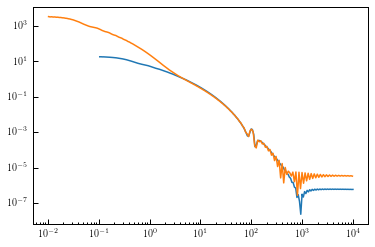

In [23]:
plt.figure()
plt.plot(r_linear,np.fabs(xi_linear))
plt.plot(r_nonlin,np.fabs(xi_nonlin))
plt.xscale('log')
plt.yscale('log')
plt.show()

In [45]:
from hmf import cosmo, growth_factor

In [46]:
c = cosmo.Planck15

In [22]:
g = growth_factor.GrowthFactor(c)

In [23]:
g.growth_factor(1.0)
gf = g.growth_factor_fn()

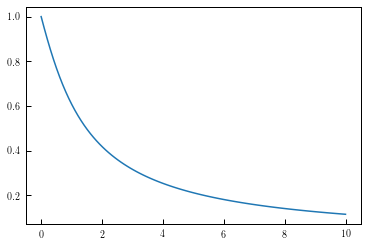

In [24]:
z = np.linspace(0,10,100)
plt.figure()
plt.plot(z,gf(z))
plt.show()

In [14]:
from hmf import growth_factor
from hmf import cosmo as hmf_cosmo
from camb import model, initialpower
import numpy as np
from astropy import units as u
import astropy.constants as const

# set up a new set of parameters for CAMB
pars = camb.CAMBparams()

def mean_density(cosmo, z):
    """
    mean density of the universe
    
    Paramaters
    ----------
    z : array_like
        redshift
    
    cosmo : astropy.cosmology object
    
    Returns
    -------
    rho_b : numpy.array
         mean density of the universe at redshift z in Msol/Mpc^3
    """
    
    scale_factor = 1.0/(1.0+z)
    
    rho = (3.0/(8.0*np.pi*const.G))*(cosmo.H(z)**2)*(cosmo.Om(z)*scale_factor**(-3))
    rho = rho.to(u.M_sun  / u.parsec**3)*((10**6)**3)
    
    return rho.value


def linear_power_spectrum(cosmo, z, lmax=2500, minkh=1e-4, maxkh=1):
    """
    Parameters
    ==========

    Returns
    =======
    k : numpy.array
        k for which the power specturm is calculated

    z : numpy.array
        redshifts for which the power epctrum is calculated

    pk : numpy.array
        power spectrum(s) at the specified k for each redshift
    """

    z = np.atleast_1D(z)

    pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
    pars.InitPower.set_params(ns=0.965, r=0)
    pars.set_for_lmax(lmax, lens_potential_accuracy=0)

    # calculate results for these parameters
    results = camb.get_results(pars)

    # now get matter power spectra and sigma8 at the specified  redshift
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
    pars.set_dark_energy() #re-set defaults
    pars.InitPower.set_params(ns=0.965)
    # not non-linear corrections couples to smaller scales than you want
    pars.set_matter_power(redshifts=z, kmax=maxkh*2)

    # linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(minkh=minkh, maxkh=maxkh, npoints=200)

    return kh, z, pk


def linear_growth_factor(cosmo, z):
    """
    linear growth factor normalized to 1.0 at z=0.0
    """
    
    # get growth factor object
    g = growth_factor.GrowthFactor(cosmo)
    
    # get spline function
    gf = g.growth_factor_fn()
    
    # return growth factor at desired redshift
    return gf(z)


def P_II_factor(cosmo, z):
    """
    alignment shape-shape linear power spectrum factor
    """
    C_1 = 5*10**(-14)
    return (C_1*mean_density(cosmo, z)/((1.0+z)*linear_growth_factor(cosmo, z)))**2

def P_GI_factor(cosmo, z):
    """
    alignment shape-shape linear power spectrum factor
    """
    C_1 = 5*10**(-14)
    return (C_1*mean_density(cosmo, z)/((1.0+z)*linear_growth_factor(cosmo, z)))

In [4]:
from astropy.cosmology import Planck15
cosmo = Planck15

In [5]:
P_II_factor(cosmo, 0.0)

3.834034041238135e-06

In [46]:
r_linear, xi_linear = pk2xi(kh, pk[0])
r_nonlin, xi_nonlin = pk2xi(kh_nonlin, pk_nonlin[0])

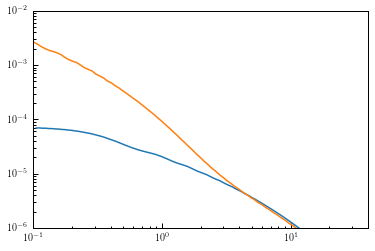

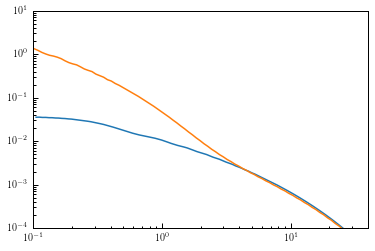

In [56]:
plt.figure()
plt.plot(r_linear,P_II_factor(cosmo, 0.0)*xi_linear)
plt.plot(r_nonlin,P_II_factor(cosmo, 0.0)*xi_nonlin)
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.1,40])
plt.ylim([0.000001,0.01])
plt.show()

plt.figure()
plt.plot(r_linear,P_GI_factor(cosmo, 0.0)*xi_linear)
plt.plot(r_nonlin,P_GI_factor(cosmo, 0.0)*xi_nonlin)
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.1,40])
plt.ylim([0.0001,10])
plt.show()

In [57]:
from scipy import interpolate
xi_pp_lin = interpolate.interp1d(np.log10(r_linear),np.log10(P_II_factor(cosmo, 0.0)*np.fabs(xi_linear)), fill_value='extrapolate')
xi_pp_nonlin = interpolate.interp1d(np.log10(r_nonlin),np.log10(P_II_factor(cosmo, 0.0)*np.fabs(xi_nonlin)), fill_value='extrapolate')


In [58]:
def integrand_1(x, y):
    r = np.sqrt(x*x + y*y)
    return 2*10**xi_pp_lin(np.log10(r))

def integrand_2(x, y):
    r = np.sqrt(x*x + y*y)
    return 2*10**xi_pp_nonlin(np.log10(r))

In [59]:
import scipy.integrate as integrate

rp_bins = np.logspace(-1,2,20)
w_pp_linear = np.zeros(len(rp_bins))
w_pp_nonlin = np.zeros(len(rp_bins))
for i in range(0,len(rp_bins)):
    w_pp_linear[i] = integrate.quad(integrand_1, 0, 100, args=(rp_bins[i],))[0]
    w_pp_nonlin[i] = integrate.quad(integrand_2, 0, 100, args=(rp_bins[i],))[0]

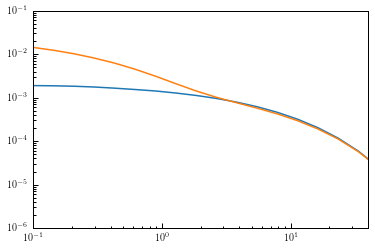

In [61]:
plt.figure()
plt.plot(rp_bins,10*w_pp_linear)
plt.plot(rp_bins,10*w_pp_nonlin)
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.1,40])
plt.ylim([0.000001,0.1])
plt.show()



In [62]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolshoi', halo_finder='rockstar', redshift=0, version_name='halotools_v0p4')

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [66]:
# galaxy coordinates and orientations
coords = np.vstack((halocat.halo_table['halo_x'],
                    halocat.halo_table['halo_y'],
                    halocat.halo_table['halo_z'])).T

orientations = np.vstack((halocat.halo_table['halo_axisA_x'],
                          halocat.halo_table['halo_axisA_y'],
                          halocat.halo_table['halo_axisA_z'])).T

In [92]:
from halotools.mock_observables.alignments import ii_plus_3d, ii_minus_3d

e = np.random.random(len(halocat.halo_table))

In [76]:
mask=(halocat.halo_table['halo_mpeak']>10**12)

In [73]:
(1-halocat.halo_table['halo_c_to_a']**2)/(1+halocat.halo_table['halo_c_to_a']**2)

0.49540177
0.65164965
0.24827816
0.65988725
0.48795906
0.5756345
0.49864933
0.14499147
0.66059804
0.5150936
0.5762659


In [99]:
e = halocat.halo_table['halo_c_to_a']*0.0+0.5

In [100]:
rbins = np.logspace(-1,np.log10(40))
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

result = ii_minus_3d(coords[mask], orientations[mask], e[mask], coords[mask], orientations[mask], e[mask],
           rbins, period=halocat.Lbox, num_threads=4)

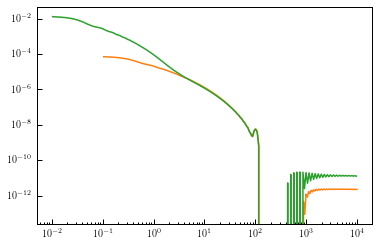

In [94]:
plt.figure()
plt.plot(rbin_centers, result, 'o')
plt.plot(r_linear,P_II_factor(cosmo, 0.0)*xi_linear)
plt.plot(r_nonlin,P_II_factor(cosmo, 0.0)*xi_nonlin)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [102]:
result

array([-3.37345504e+01, -3.70225606e+01, -2.43116935e+01, -2.04109213e+01,
       -1.69691952e+01, -1.24328001e+01, -8.45935879e+00, -7.58472798e+00,
       -7.21073726e+00, -6.25286875e+00, -5.28229522e+00, -3.93404023e+00,
       -2.92824298e+00, -2.03505854e+00, -1.81465933e+00, -1.42338151e+00,
       -1.11421075e+00, -9.50191757e-01, -7.98734079e-01, -5.89925513e-01,
       -5.03192849e-01, -4.08457210e-01, -3.21325082e-01, -2.47267035e-01,
       -1.98597388e-01, -1.71043935e-01, -1.43563297e-01, -1.26322476e-01,
       -1.06721587e-01, -9.78130772e-02, -8.01599332e-02, -7.06341028e-02,
       -6.32241504e-02, -5.84333765e-02, -5.25413390e-02, -4.77774768e-02,
       -4.40494713e-02, -4.11673412e-02, -3.79821747e-02, -3.61383641e-02,
       -3.37830642e-02, -3.23216320e-02, -3.12100058e-02, -3.03315822e-02,
       -2.94789295e-02, -2.90848391e-02, -2.84878654e-02, -2.81113058e-02,
       -2.77874445e-02])